In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

In [2]:
Poore_COAD = pd.read_csv("Poore_COAD", index_col=0)
Poore_COAD

,f__Halomonadaceae; g__Cobetia,f__Thermoanaerobacteraceae; g__Ammonifex,f__Cryomorphaceae; g__Owenweeksia,f__Haloplasmataceae; g__Haloplasma,f__Desulfobacteraceae; g__Desulfosarcina,f__Enterobacteriaceae; g__Siccibacter,f__Acetobacteraceae; g__Asaia,f__Rhodobiaceae; g__Parvibaculum,g__Neosynechococcus,f__Sphingomonadaceae; g__Zymomonas,...,portion_weight,aliquot_concentration,analyte_A260A280Ratio,analyte_amount,analyte_type_label,radiation_therapy_code_label,radiation_therapy_site_label,radiation_therapy_type_label,year_of_diagnosis,vital_status_label
sample_id1,,,,,,,,,,,,,,,,,,,,,
s13008,0.549996,3.627426,1.243335,0.200708,-0.019726,3.566605,1.143794,3.529965,1.626574,-0.920077,...,36.0,0.14,1.80,147.30,RNA,NaN,NaN,NaN,2009.0,Alive
s12994,1.036992,2.472233,1.813183,0.705863,-0.388531,1.471217,1.448203,1.290475,2.069139,-0.342958,...,110.0,0.15,1.72,132.38,RNA,NaN,NaN,NaN,2006.0,Dead
s13005,0.391081,4.148250,3.489199,0.059951,-1.034442,0.825306,2.387254,3.451919,3.745155,0.596093,...,137.0,0.17,1.80,583.30,RNA,NaN,NaN,NaN,2002.0,Dead
s12987,0.307795,1.743036,2.668948,-0.023334,-1.117728,0.742020,2.303968,0.561278,1.339942,-1.072154,...,158.0,0.14,1.80,438.30,RNA,NaN,NaN,NaN,2007.0,Alive
s12895,1.091898,2.527139,1.868089,2.345731,1.251338,1.526123,1.503109,1.345381,2.124045,-0.288051,...,114.0,0.13,1.80,533.30,RNA,NaN,NaN,NaN,2009.0,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s13862,0.955064,2.390305,1.731255,0.623935,1.114504,1.389289,3.688203,1.208548,1.987211,-0.424885,...,110.0,0.15,1.73,239.76,RNA,NaN,NaN,NaN,2009.0,Alive
s13849,2.017887,1.819532,0.994857,4.463031,-1.705226,0.701323,0.955917,0.587535,1.494217,-1.100823,...,129.0,0.15,1.80,877.30,RNA,NaN,NaN,NaN,2009.0,Alive
s13857,3.343320,2.743249,2.314112,1.020499,3.378589,3.974225,1.981555,1.969840,2.411123,0.229642,...,36.0,0.14,1.70,19.80,RNA,951909FD-4B2B-4D3F-918A-34269D0A70FC,Primary Tumor Field,EXTERNAL BEAM,2008.0,Alive


In [3]:
class_counts = Poore_COAD['sample_type'].value_counts()
print(class_counts)

sample_type
Primary Tumor           825
Blood Derived Normal    109
Solid Tissue Normal      70
Metastatic                1
Recurrent Tumor           1
Name: count, dtype: int64


In [8]:
# Prepare features and target variable
X = Poore_COAD.drop(['gdc_file_uuid', 'filename', 'age_at_diagnosis', 'aliquot_uuid',
       'case_uuid', 'days_to_death', 'disease_type', 'ethnicity',
       'experimental_strategy', 'gender', 'investigation', 'platform',
       'primary_site', 'race', 'reference_genome', 'sample_type',
       'sample_uuid', 'vital_status', 'tissue_source_site_label',
       'data_submitting_center_label', 'country_of_sample_procurement',
       'histological_diagnosis_label', 'pathologic_t_label',
       'pathologic_n_label', 'pathologic_stage_label', 'icd03_histology_label',
       'icd03_histology_site', 'icd10', 'portion_is_ffpe',
       'new_tumor_event_after_initial_trtmt',
       'primary_therapy_outcome_success_label', 'portion_weight',
       'aliquot_concentration', 'analyte_A260A280Ratio', 'analyte_amount',
       'analyte_type_label', 'radiation_therapy_code_label',
       'radiation_therapy_site_label', 'radiation_therapy_type_label',
       'year_of_diagnosis', 'vital_status_label'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled
y = Poore_COAD['sample_type']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))

Unique values of y: ['Blood Derived Normal' 'Metastatic' 'Primary Tumor' 'Recurrent Tumor'
 'Solid Tissue Normal']
Unique values of y: [0 1 2 3 4]


In [9]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_scaled, y = oversampler.fit_resample(X_scaled,y)
print(X_scaled.shape)
print(y.shape)

(4125, 1273)
(4125,)


In [11]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

random_seed = 42
lsvc = LinearSVC(C = 0.01, penalty="l1", dual=False).fit(X_scaled, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_scaled)

X_new.shape

(4125, 338)

Best Parameters: {'alpha': 0.01, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Best Score: 0.9923803469802642
Test Set Accuracy: 0.9951534733441034


<Figure size 800x600 with 0 Axes>

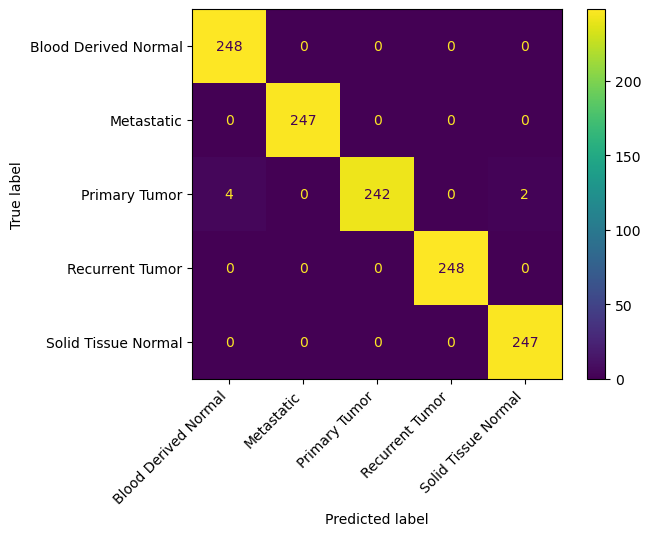

In [12]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'learning_rate':[0.01, 0.1],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1],
    #'lambda': [0.1, 1]
    'alpha': [0.01, 0.1],
    'n_estimators': [50, 100]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=5, eval_metric='mlogloss', seed=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the model on the test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

# Get the predicted labels
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blood Derived Normal', 'Metastatic', 'Primary Tumor', 'Recurrent Tumor',
 'Solid Tissue Normal'])
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
cm_display.plot()  # Plot confusion matrix
plt.xticks(rotation=45, ha='right')  # Rotate x-labels by 45 degrees
plt.show()

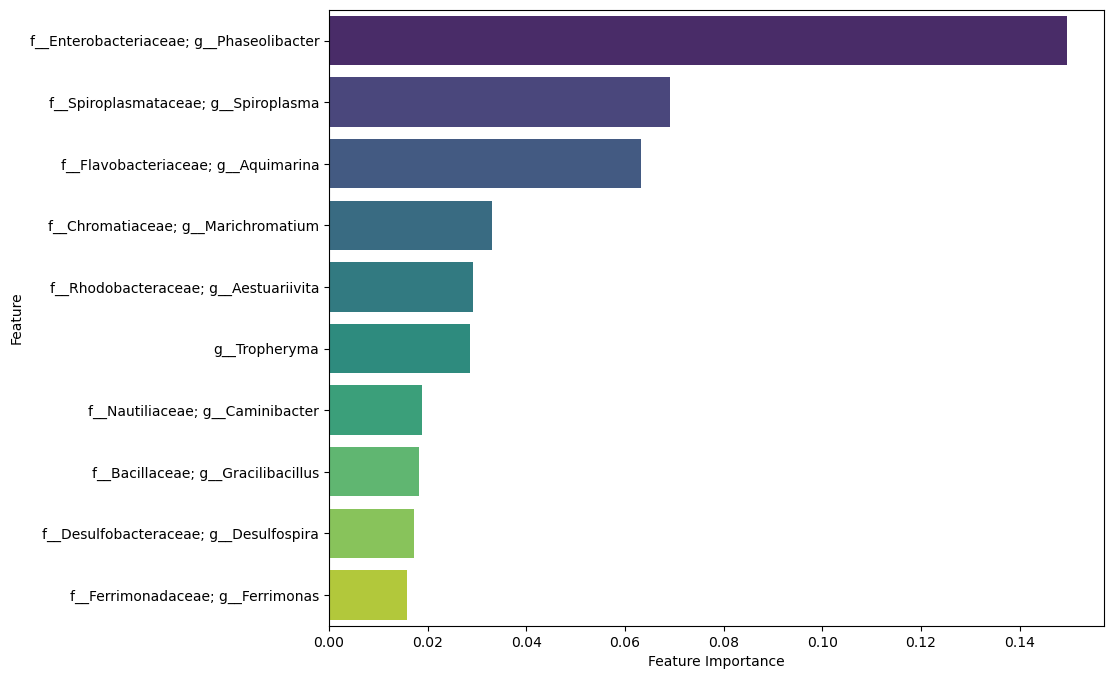

In [13]:
# Train XGBoost model with best parameters
best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=5, eval_metric='mlogloss', **best_params)
best_xgb_model.fit(X_train, y_train)
# Get feature importances
feature_importances = best_xgb_model.feature_importances_

# Get indices of top 10 features
top_10_indices = feature_importances.argsort()[::-1][:10]

# Get feature names
feature_names = X.columns

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_10_indices], y=feature_names[top_10_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

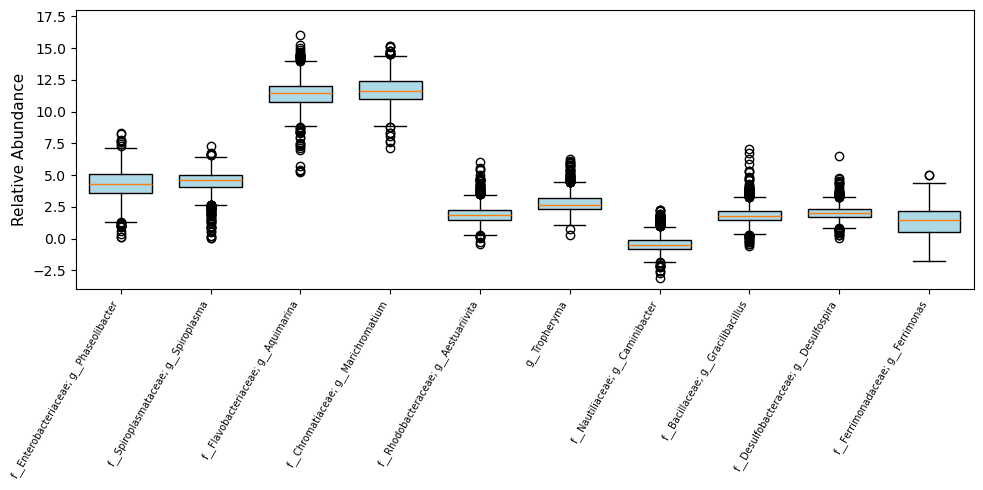

In [16]:

data = {}
top_20_feature_names = feature_names[top_10_indices]
#abundance_scaled = np.log2(X+10)

# Iterate over the columns of the DataFrame
for column_name in top_20_feature_names:
    data[column_name] = X[column_name]

plt.figure(figsize=(10, 5))
# Creating a box plot
plt.boxplot(data.values(), widths=0.7, patch_artist=True, 
            boxprops=dict(facecolor='lightblue'), whiskerprops=dict(color='black'))

plt.ylim(-4, 18)
plt.ylabel('Relative Abundance', fontsize=11)

# Adding x-axis tick labels
plt.xticks(range(1, len(data) + 1), data.keys(), rotation=60, ha='right', fontsize=7)  # Adjust fontsize here

# Displaying the plot
plt.tight_layout()  # Adjusts subplot parameters to give specified padding
plt.show()